In [1]:
import numpy as np
import pandas as pd
import pickle
import sys
import os
import dsc
from dsc.query_engine import Query_Processor as dscQP
from dsc import dsc_io

import matplotlib.pyplot as plt
from pymir import mpl_stylesheet
from pymir import mpl_utils
mpl_stylesheet.banskt_presentation(splinecolor = 'black', dpi = 300)

import utils

In [2]:
def stratify_dfcol(df, colname, value):
    #return pd_utils.select_dfrows(df, [f"$({colname}) == {value}"])
    return df.loc[df[colname] == value]

def stratify_dfcols(df, condition_list):
    for (colname, value) in condition_list:
        df = stratify_dfcol(df, colname, value)
    return df

def stratify_dfcols_in_list(df, colname, values):
    return df.loc[df[colname].isin(values)]

In [4]:
dsc_output = "/home/saikatbanerjee/scratch/work/gradvi-experiments/linreg_corr_runtime"
dsc_fname  = os.path.basename(os.path.normpath(dsc_output))
db = os.path.join(dsc_output, dsc_fname + ".db")
elbopkl   = os.path.join("../dsc/results", dsc_fname + "_elbo.pkl")
dscoutpkl = os.path.join("../dsc/results", dsc_fname + "_dscout.pkl")
msepkl    = os.path.join("../dsc/results", dsc_fname + "_mse.pkl")
niterpkl  = os.path.join("../dsc/results", dsc_fname + "_niter.pkl")
dscout    = pd.read_pickle(dscoutpkl)

refresh_pickle = False

print(db)
plotprefix = "compare_niter_linreg_blockcorr"

/home/saikatbanerjee/scratch/work/gradvi-experiments/linreg_corr_runtime/linreg_corr_runtime.db


In [5]:
target = ["simulate", "simulate.sfix", "simulate.pve", "simulate.se", "simulate.dims", "fit", "fit.DSC_TIME"]
#condition = ["simulate.sfix == 2", "simulate.signal == 'normal'", "simulate.dims == '(50, 200)'"]
#groups = ["fit_cpt:"]
condition = [""]

In [6]:
qp = dscQP(db, target, condition)
df = qp.output_table
df

,DSC,simulate,simulate.sfix,simulate.se:output,simulate.pve,simulate.output.file,simulate.dims,fit,fit.output.file,fit.DSC_TIME:output
0,1,blockdiag,20,blockdiag/blockdiag_1,0.6,blockdiag/blockdiag_1,"(500,10000)",mr_ash_lasso_init,mr_ash_lasso_init/blockdiag_1_lasso_1_mr_ash_l...,mr_ash_lasso_init/blockdiag_1_lasso_1_mr_ash_l...
1,2,blockdiag,20,blockdiag/blockdiag_2,0.6,blockdiag/blockdiag_2,"(500,10000)",mr_ash_lasso_init,mr_ash_lasso_init/blockdiag_2_lasso_1_mr_ash_l...,mr_ash_lasso_init/blockdiag_2_lasso_1_mr_ash_l...
2,3,blockdiag,20,blockdiag/blockdiag_3,0.6,blockdiag/blockdiag_3,"(500,10000)",mr_ash_lasso_init,mr_ash_lasso_init/blockdiag_3_lasso_1_mr_ash_l...,mr_ash_lasso_init/blockdiag_3_lasso_1_mr_ash_l...
3,4,blockdiag,20,blockdiag/blockdiag_4,0.6,blockdiag/blockdiag_4,"(500,10000)",mr_ash_lasso_init,mr_ash_lasso_init/blockdiag_4_lasso_1_mr_ash_l...,mr_ash_lasso_init/blockdiag_4_lasso_1_mr_ash_l...
4,5,blockdiag,20,blockdiag/blockdiag_5,0.6,blockdiag/blockdiag_5,"(500,10000)",mr_ash_lasso_init,mr_ash_lasso_init/blockdiag_5_lasso_1_mr_ash_l...,mr_ash_lasso_init/blockdiag_5_lasso_1_mr_ash_l...
...,...,...,...,...,...,...,...,...,...,...
295,96,blockdiag,20,blockdiag/blockdiag_96,0.6,blockdiag/blockdiag_96,"(500,10000)",gradvi_compound_lasso_init,gradvi_compound_lasso_init/blockdiag_96_lasso_...,gradvi_compound_lasso_init/blockdiag_96_lasso_...
296,97,blockdiag,20,blockdiag/blockdiag_97,0.6,blockdiag/blockdiag_97,"(500,10000)",gradvi_compound_lasso_init,gradvi_compound_lasso_init/blockdiag_97_lasso_...,gradvi_compound_lasso_init/blockdiag_97_lasso_...
297,98,blockdiag,20,blockdiag/blockdiag_98,0.6,blockdiag/blockdiag_98,"(500,10000)",gradvi_compound_lasso_init,gradvi_compound_lasso_init/blockdiag_98_lasso_...,gradvi_compound_lasso_init/blockdiag_98_lasso_...
298,99,blockdiag,20,blockdiag/blockdiag_99,0.6,blockdiag/blockdiag_99,"(500,10000)",gradvi_compound_lasso_init,gradvi_compound_lasso_init/blockdiag_99_lasso_...,gradvi_compound_lasso_init/blockdiag_99_lasso_...


In [7]:
def read_result(df, method):
    '''
    must be a single row after method selection
    '''
    dfm = stratify_dfcol(df, "fit", method)
    assert(dfm.shape[0] == 1)
    fprefix = dfm['fit.output.file'].values[0]
    ext = 'pkl' if method.startswith('gradvi') else 'rds'
    fname = os.path.join(dsc_output, f"{fprefix}.{ext}")
    data = dsc_io.load_dsc(fname)
    return data


def get_niter_from_result(data, method):
    if method.startswith('gradvi'):
        return data['model']['niter']
    else:
        return data['model']['fit']['iter']
    

def get_convergence_from_result(data, method, mrash_maxiter = 2000):
    '''
    1: converged
    2: abnormal termination
    3: number of iterations reached limit
    4: unknown
    '''
    if method.startswith('gradvi'):
        success = data['model']['success']
        if success:
            conv_status = 1
        else:
            conv_message = data['model']['fitobj']['message']
            if "ITERATIONS REACHED LIMIT" in conv_message:
                conv_status = 3
            elif "ABNORMAL_TERMINATION_IN_LNSRCH" in conv_message:
                conv_status = 2
            else:
                conv_status = 4
    else:
        niter = data['model']['fit']['iter']
        if niter == mrash_maxiter:
            conv_status = 3
        else:
            conv_status = 1
    return conv_status

    
def get_niter_df(df):
    methods = df['fit'].unique()
    sfixs   = df['simulate.sfix'].unique()
    pves    = df['simulate.pve'].unique()
    resdict = {'simulate.sfix': [], 'simulate.pve': [], 'DSC': [], 
               **{x: [] for x in methods}, 
               **{f"{x}_status": [] for x in methods}
              }
    for pve in pves:
        for sfix in sfixs:
            dfs = stratify_dfcols(df, [('simulate.sfix', sfix), ("simulate.pve", pve)])

            dscids = dfs['DSC'].unique()
            for idsc in dscids:
                dfs0 = stratify_dfcol(dfs, 'DSC', idsc)
                resdict['simulate.sfix'].append(sfix)
                resdict['simulate.pve'].append(pve)
                resdict['DSC'].append(idsc)
                for method in methods:
                    data = read_result(dfs0, method)
                    niter = get_niter_from_result(data, method)
                    conv_status = get_convergence_from_result(data, method)
                    resdict[method].append(niter)
                    resdict[f"{method}_status"].append(conv_status)
    return pd.DataFrame.from_dict(resdict)

In [8]:
def get_elbo_from_result(data, method):
    if method.startswith('gradvi'):
        return data['model']['elbo_path'][-1]
    else:
        return data['model']['fit']['varobj'][-1]
    

def get_mse_from_dscout(df, sfix, pve, dsc, method):
    dfrows = stratify_dfcols(df, 
                             [("simulate.sfix", sfix), 
                              ("simulate.pve", pve), 
                              ("DSC", dsc), 
                              ("fit", method)])
    mse = dfrows[~dfrows['mse.err'].isnull()]['mse.err'].values
    if len(mse) == 1:
        return mse[0]
    else:
        print ("Error fetching value")
        return mse[0]
    
def get_elbodf(df):
    methods = df['fit'].unique()
    sfixs   = df['simulate.sfix'].unique()
    pves    = df['simulate.pve'].unique()
    resdict = {'simulate.sfix': [], 'simulate.pve': [], 'DSC': [], 
               **{x: [] for x in methods}, 
               **{f"{x}_status": [] for x in methods}
              }
    for pve in pves:
        for sfix in sfixs:
            dfs = stratify_dfcols(df, [('simulate.sfix', sfix), ("simulate.pve", pve)])

            dscids = dfs['DSC'].unique()
            for idsc in dscids:
                dfs0 = stratify_dfcol(dfs, 'DSC', idsc)
                resdict['simulate.sfix'].append(sfix)
                resdict['simulate.pve'].append(pve)
                resdict['DSC'].append(idsc)
                for method in methods:
                    data = read_result(dfs0, method)
                    elbo = get_elbo_from_result(data, method)
                    conv_status = get_convergence_from_result(data, method)
                    resdict[method].append(elbo)    
                    resdict[f"{method}_status"].append(conv_status)
    return pd.DataFrame.from_dict(resdict)

def get_msedf(elbodf, dscdf):
    methods = [x[:-7] for x in list(elbodf.columns) if x.endswith("_status")]
    msedict = elbodf.to_dict()
    ikeys = list(msedict['simulate.sfix'].keys())
    for method in methods:
        for i in ikeys:
            mse = get_mse_from_dscout(dscout, 
                          msedict['simulate.sfix'][i], 
                          msedict['simulate.pve'][i],
                          msedict['DSC'][i], 
                          method)
            msedict[method][i] = mse
    return pd.DataFrame.from_dict(msedict)

In [9]:
if refresh_pickle:
    niterdf = get_niter_df(df)
    niterdf.to_pickle(niterpkl)
else:
    niterdf = pd.read_pickle(niterpkl)

In [10]:
niterdf

,simulate.sfix,simulate.pve,DSC,mr_ash_lasso_init,gradvi_direct_lasso_init,gradvi_compound_lasso_init,mr_ash_lasso_init_status,gradvi_direct_lasso_init_status,gradvi_compound_lasso_init_status
0,20,0.6,1,2000,1109,249,3,1,1
1,20,0.6,2,544,491,158,1,1,1
2,20,0.6,3,199,359,50,1,1,1
3,20,0.6,4,86,365,183,1,1,1
4,20,0.6,5,181,181,85,1,1,1
...,...,...,...,...,...,...,...,...,...
95,20,0.6,96,713,363,139,1,1,1
96,20,0.6,97,172,512,187,1,1,1
97,20,0.6,98,47,224,103,1,1,1
98,20,0.6,99,432,656,127,1,1,1


In [11]:
if refresh_pickle:
    elbodf = get_elbodf(df)
    elbodf.to_pickle(elbopkl)
else:
    elbodf = pd.read_pickle(elbopkl)

In [12]:
if refresh_pickle:
    msedf = get_msedf(elbodf, dscout)
    msedf.to_pickle(msepkl)
else:
    msedf = pd.read_pickle(msepkl)

In [21]:
dscout

,DSC,simulate,simulate.dims,simulate.se,simulate.sfix,simulate.pve,fit,fit.DSC_TIME,mse.err,coef_mse.err
0,1,blockdiag,"(500,10000)",0.484490,20,0.6,mr_ash_lasso_init,197.362000,0.374464,NaN
1,2,blockdiag,"(500,10000)",1.674974,20,0.6,mr_ash_lasso_init,56.313000,3.164405,NaN
2,3,blockdiag,"(500,10000)",2.703665,20,0.6,mr_ash_lasso_init,19.618000,7.404005,NaN
3,4,blockdiag,"(500,10000)",1.148450,20,0.6,mr_ash_lasso_init,12.127000,1.498839,NaN
4,5,blockdiag,"(500,10000)",2.512136,20,0.6,mr_ash_lasso_init,18.783000,6.429661,NaN
...,...,...,...,...,...,...,...,...,...,...
595,96,blockdiag,"(500,10000)",0.878106,20,0.6,gradvi_compound_lasso_init,67.029293,NaN,0.001308
596,97,blockdiag,"(500,10000)",1.148360,20,0.6,gradvi_compound_lasso_init,85.102041,NaN,0.002375
597,98,blockdiag,"(500,10000)",3.633293,20,0.6,gradvi_compound_lasso_init,40.701093,NaN,0.003389
598,99,blockdiag,"(500,10000)",2.639445,20,0.6,gradvi_compound_lasso_init,46.529808,NaN,0.013346


In [27]:
#dscout_unique = dscout[dscout['mse.err'].notna()]

def get_runtime_from_dscout(df, sfix, pve, dsc, method):
    dfrows = stratify_dfcols(df, 
                             [("simulate.sfix", sfix), 
                              ("simulate.pve", pve), 
                              ("DSC", dsc), 
                              ("fit", method)])
    runtime = dfrows[~dfrows['mse.err'].isnull()]['fit.DSC_TIME'].values
    
    if len(runtime) == 1:
        return runtime[0]
    else:
        print ("Error fetching value")
        return runtime[0]

def get_runtimedf(df):
    methods = df['fit'].unique()
    sfixs   = df['simulate.sfix'].unique()
    pves    = df['simulate.pve'].unique()
    resdict = {'simulate.sfix': [], 'simulate.pve': [], 'DSC': [], 
               **{x: [] for x in methods}, 
               #**{f"{x}_status": [] for x in methods}
              }
    for pve in pves:
        for sfix in sfixs:
            dfs = stratify_dfcols(df, [('simulate.sfix', sfix), ("simulate.pve", pve)])

            dscids = dfs['DSC'].unique()
            for idsc in dscids:
                dfs0 = stratify_dfcol(dfs, 'DSC', idsc)
                resdict['simulate.sfix'].append(sfix)
                resdict['simulate.pve'].append(pve)
                resdict['DSC'].append(idsc)
                for method in methods:
                    #data = read_result(dfs0, method)
                    runtime = get_runtime_from_dscout(dscout, sfix, pve, idsc, method)
                    #conv_status = get_convergence_from_result(data, method)
                    resdict[method].append(runtime)
                    #resdict[f"{method}_status"].append(conv_status)
    return pd.DataFrame.from_dict(resdict)

runtimedf = get_runtimedf(dscout)

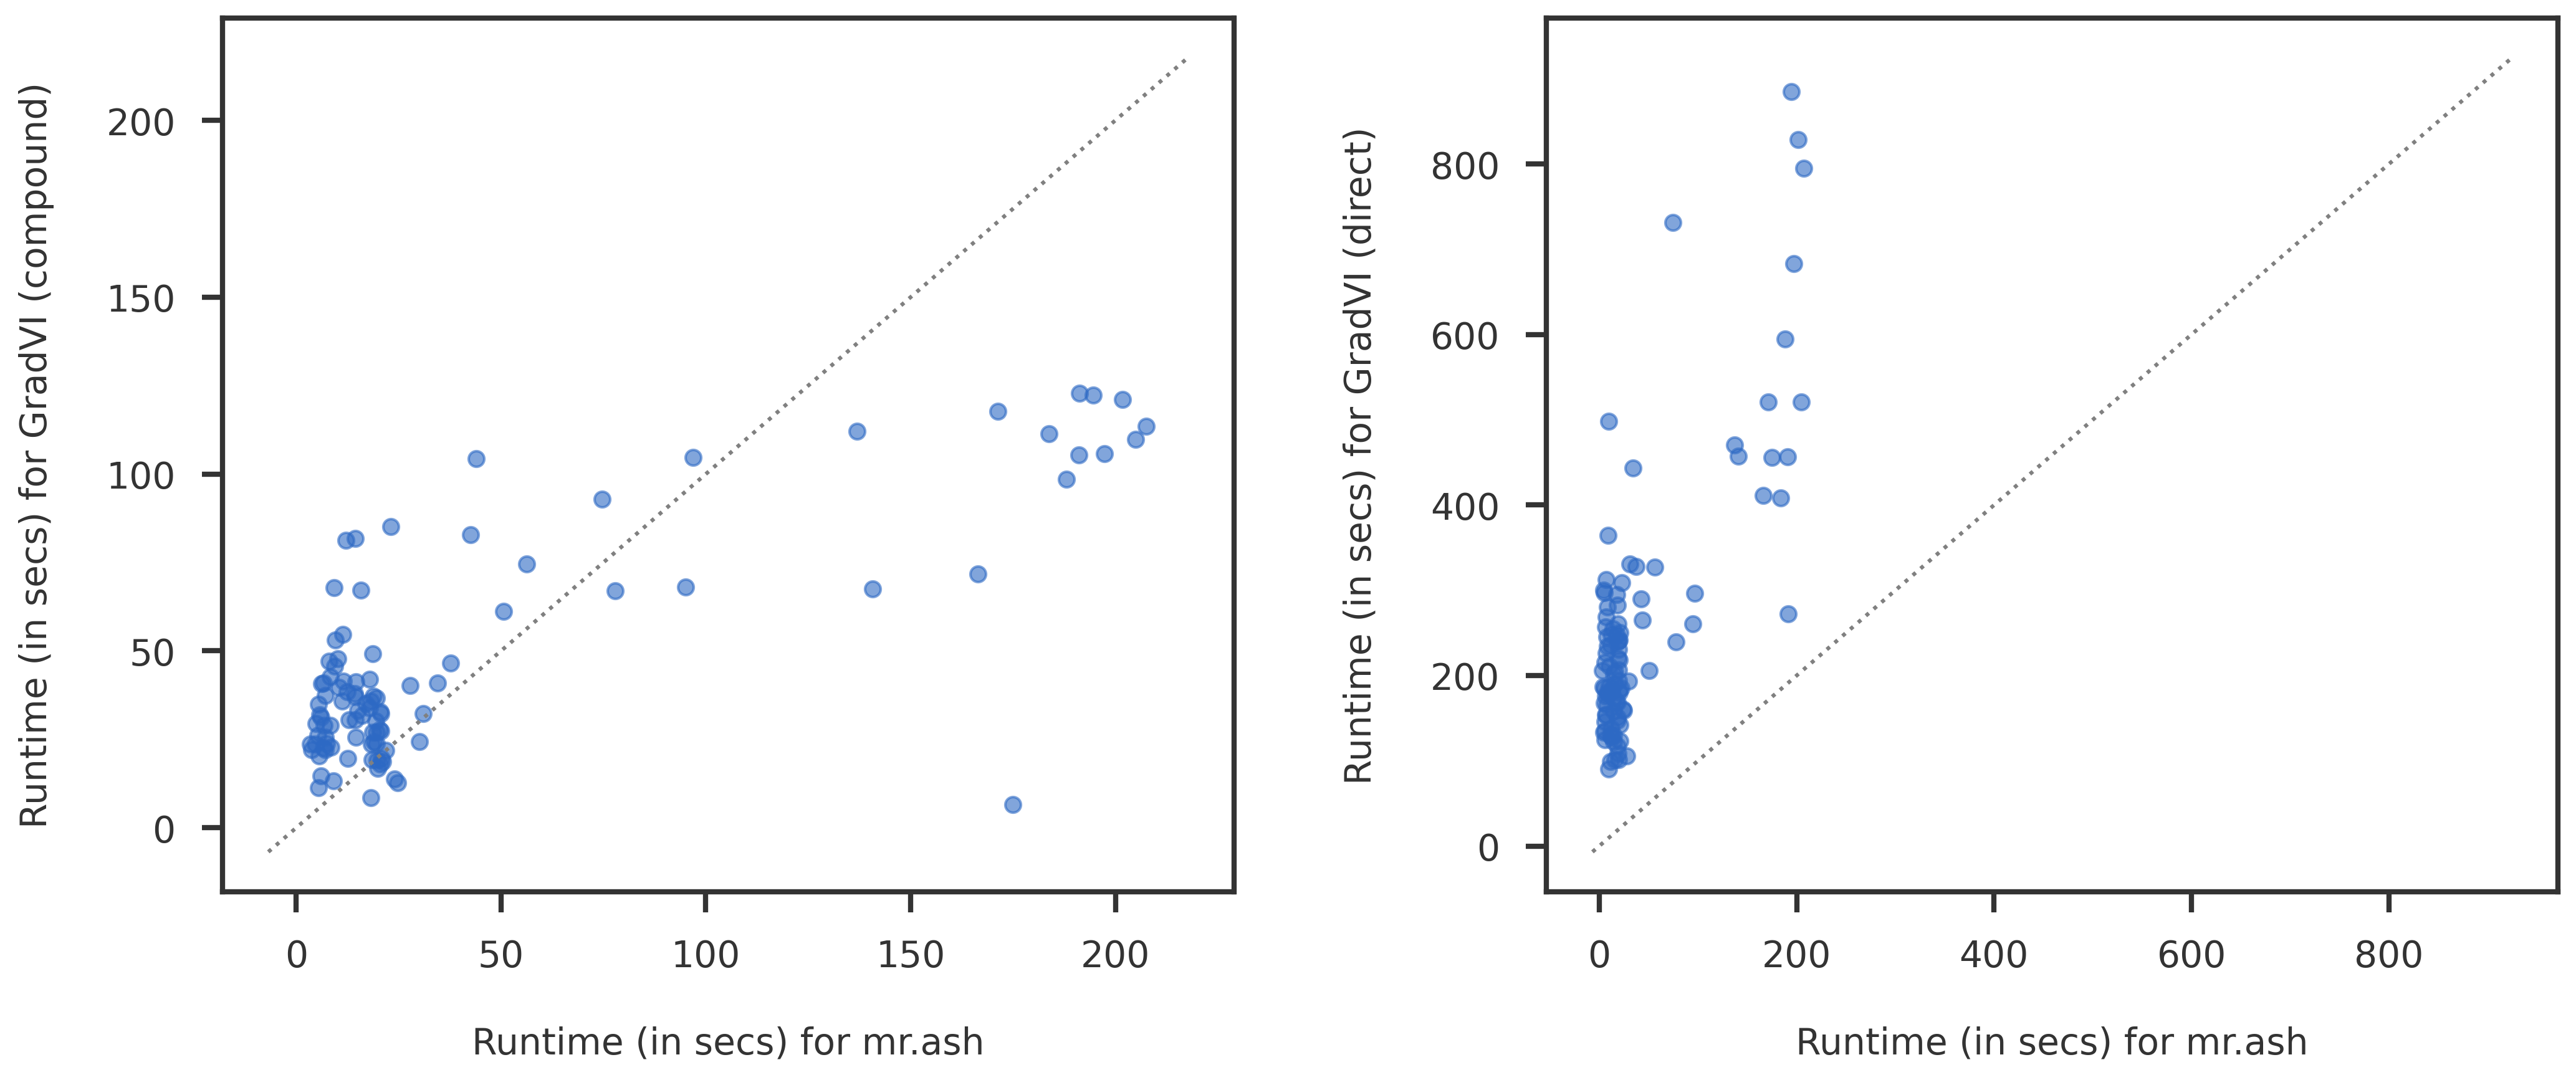

In [30]:
fig = plt.figure(figsize = (14, 6))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

#ax1.scatter(msedf['mr_ash_lasso_init'], msedf['gradvi_compound_lasso_init'])
ax1.scatter(runtimedf['mr_ash_lasso_init'], runtimedf['gradvi_compound_lasso_init'], alpha = 0.6)
#ax1.hist(elbodf['mr_ash_lasso_init'] - elbodf['gradvi_compound_lasso_init'])
mpl_utils.plot_diag(ax1)
ax1.set_xlabel("Runtime (in secs) for mr.ash")
ax1.set_ylabel("Runtime (in secs) for GradVI (compound)")

ax2.scatter(runtimedf['mr_ash_lasso_init'], runtimedf['gradvi_direct_lasso_init'], alpha = 0.6)
mpl_utils.plot_diag(ax2)
ax2.set_xlabel("Runtime (in secs) for mr.ash")
ax2.set_ylabel("Runtime (in secs) for GradVI (direct)")

plt.tight_layout(w_pad = 3.0)
utils.saveplot(fig, "linreg_corr_compare_runtime_gradvi_cavi")
plt.show()

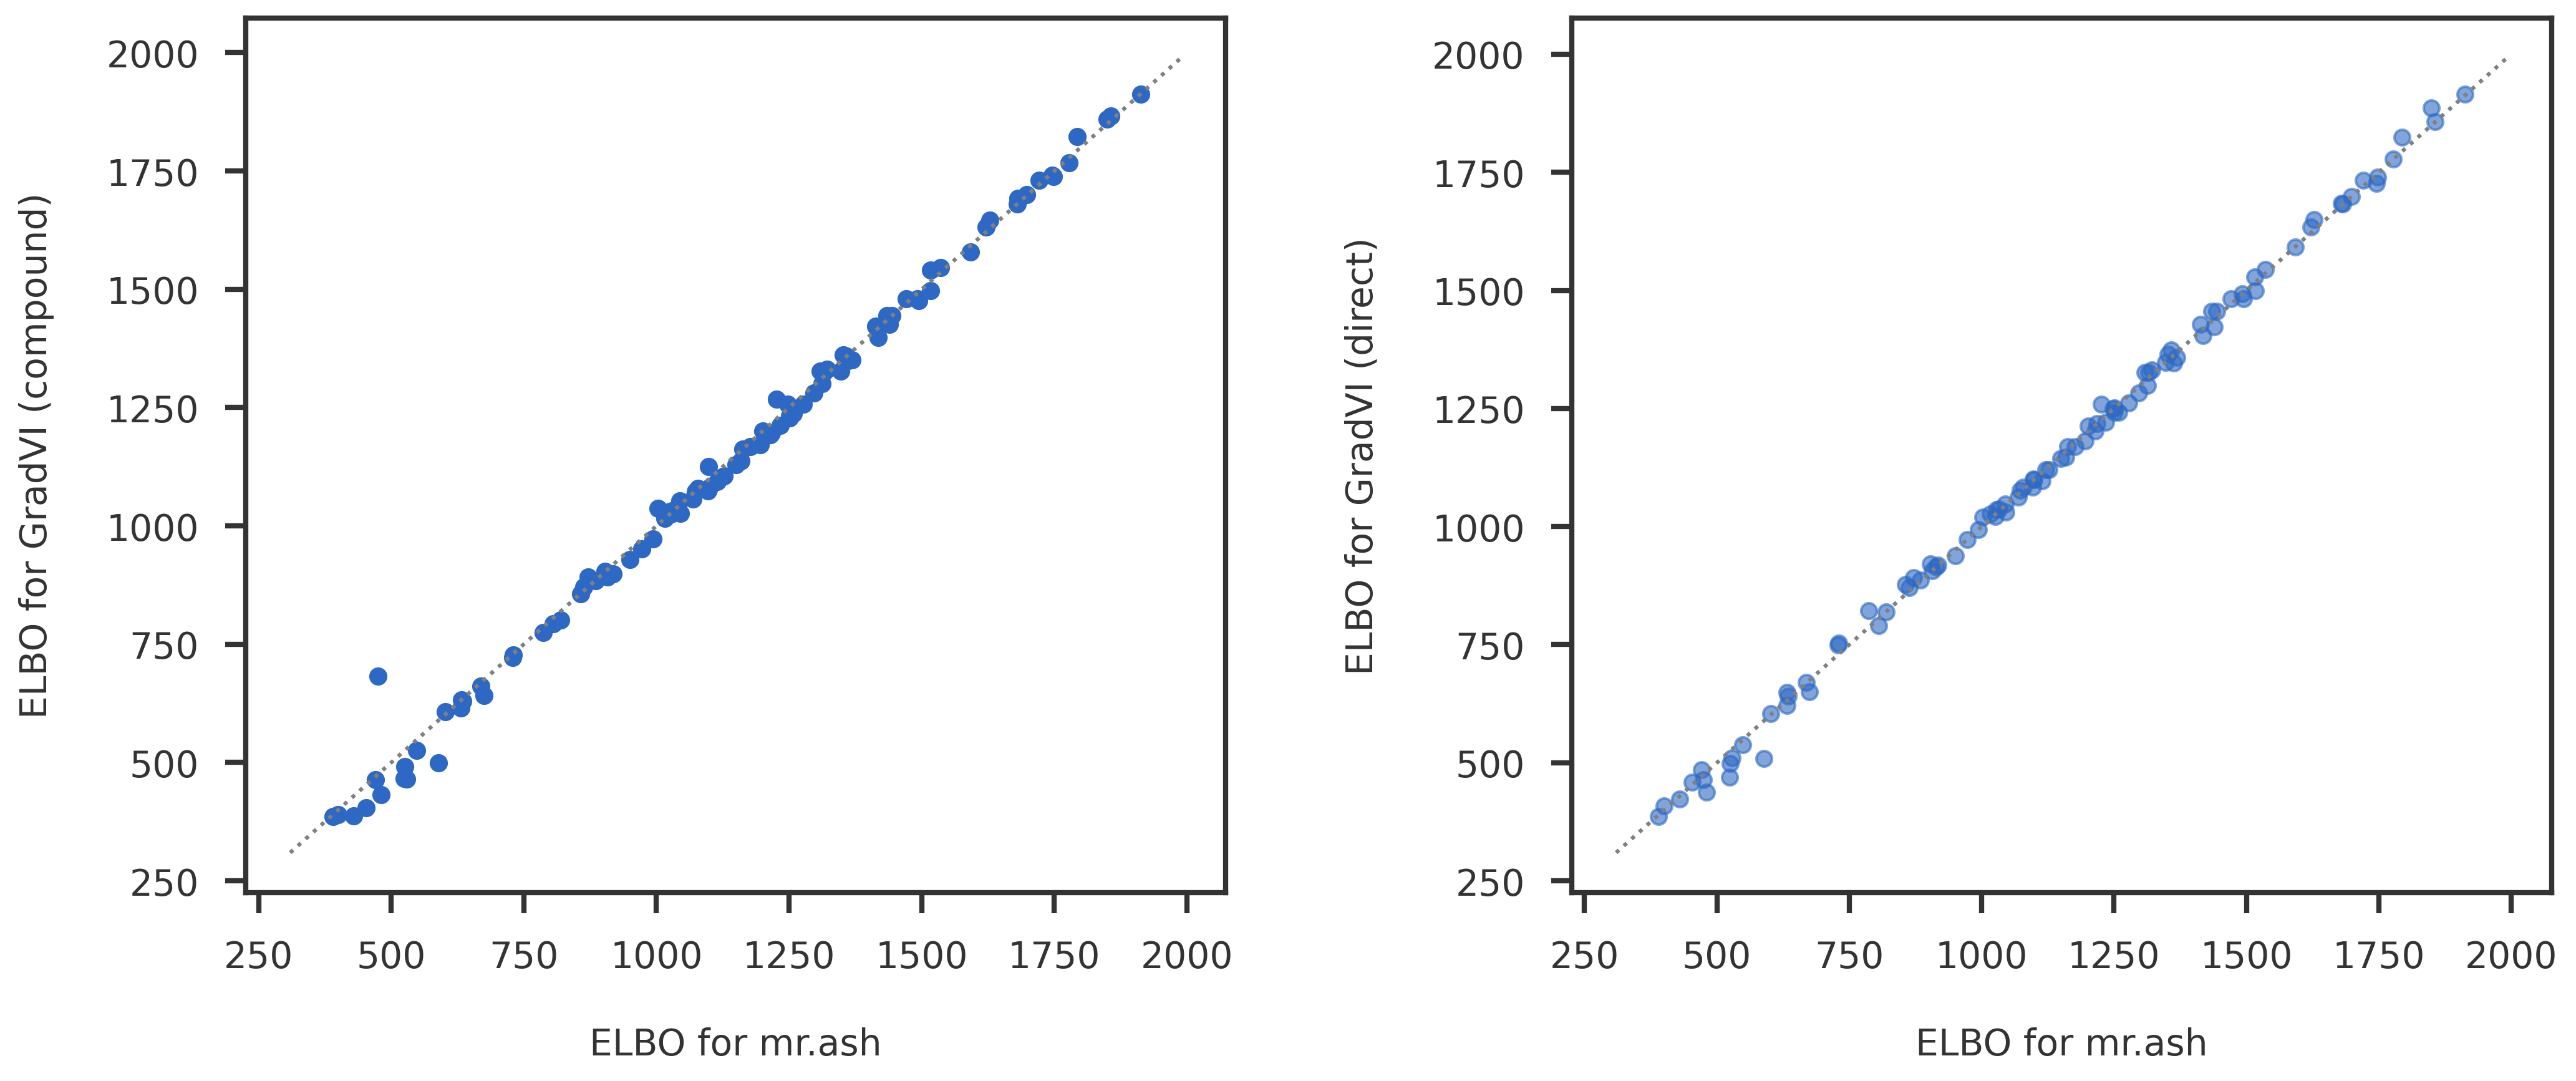

In [32]:
fig = plt.figure(figsize = (14, 6))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

#ax1.scatter(msedf['mr_ash_lasso_init'], msedf['gradvi_compound_lasso_init'])
#ax1.scatter(runtimedf['mr_ash_lasso_init'], runtimedf['gradvi_compound_lasso_init'], alpha = 0.6)
ax1.scatter(elbodf['mr_ash_lasso_init'], elbodf['gradvi_compound_lasso_init'])
mpl_utils.plot_diag(ax1)
ax1.set_xlabel("ELBO for mr.ash")
ax1.set_ylabel("ELBO for GradVI (compound)")

#ax2.scatter(runtimedf['mr_ash_lasso_init'], runtimedf['gradvi_direct_lasso_init'], alpha = 0.6)
ax2.scatter(elbodf['mr_ash_lasso_init'], elbodf['gradvi_direct_lasso_init'], alpha = 0.6)
mpl_utils.plot_diag(ax2)
ax2.set_xlabel("ELBO for mr.ash")
ax2.set_ylabel("ELBO for GradVI (direct)")

plt.tight_layout(w_pad = 3.0)
utils.saveplot(fig, "linreg_corr_compare_elbo_gradvi_cavi")
plt.show()

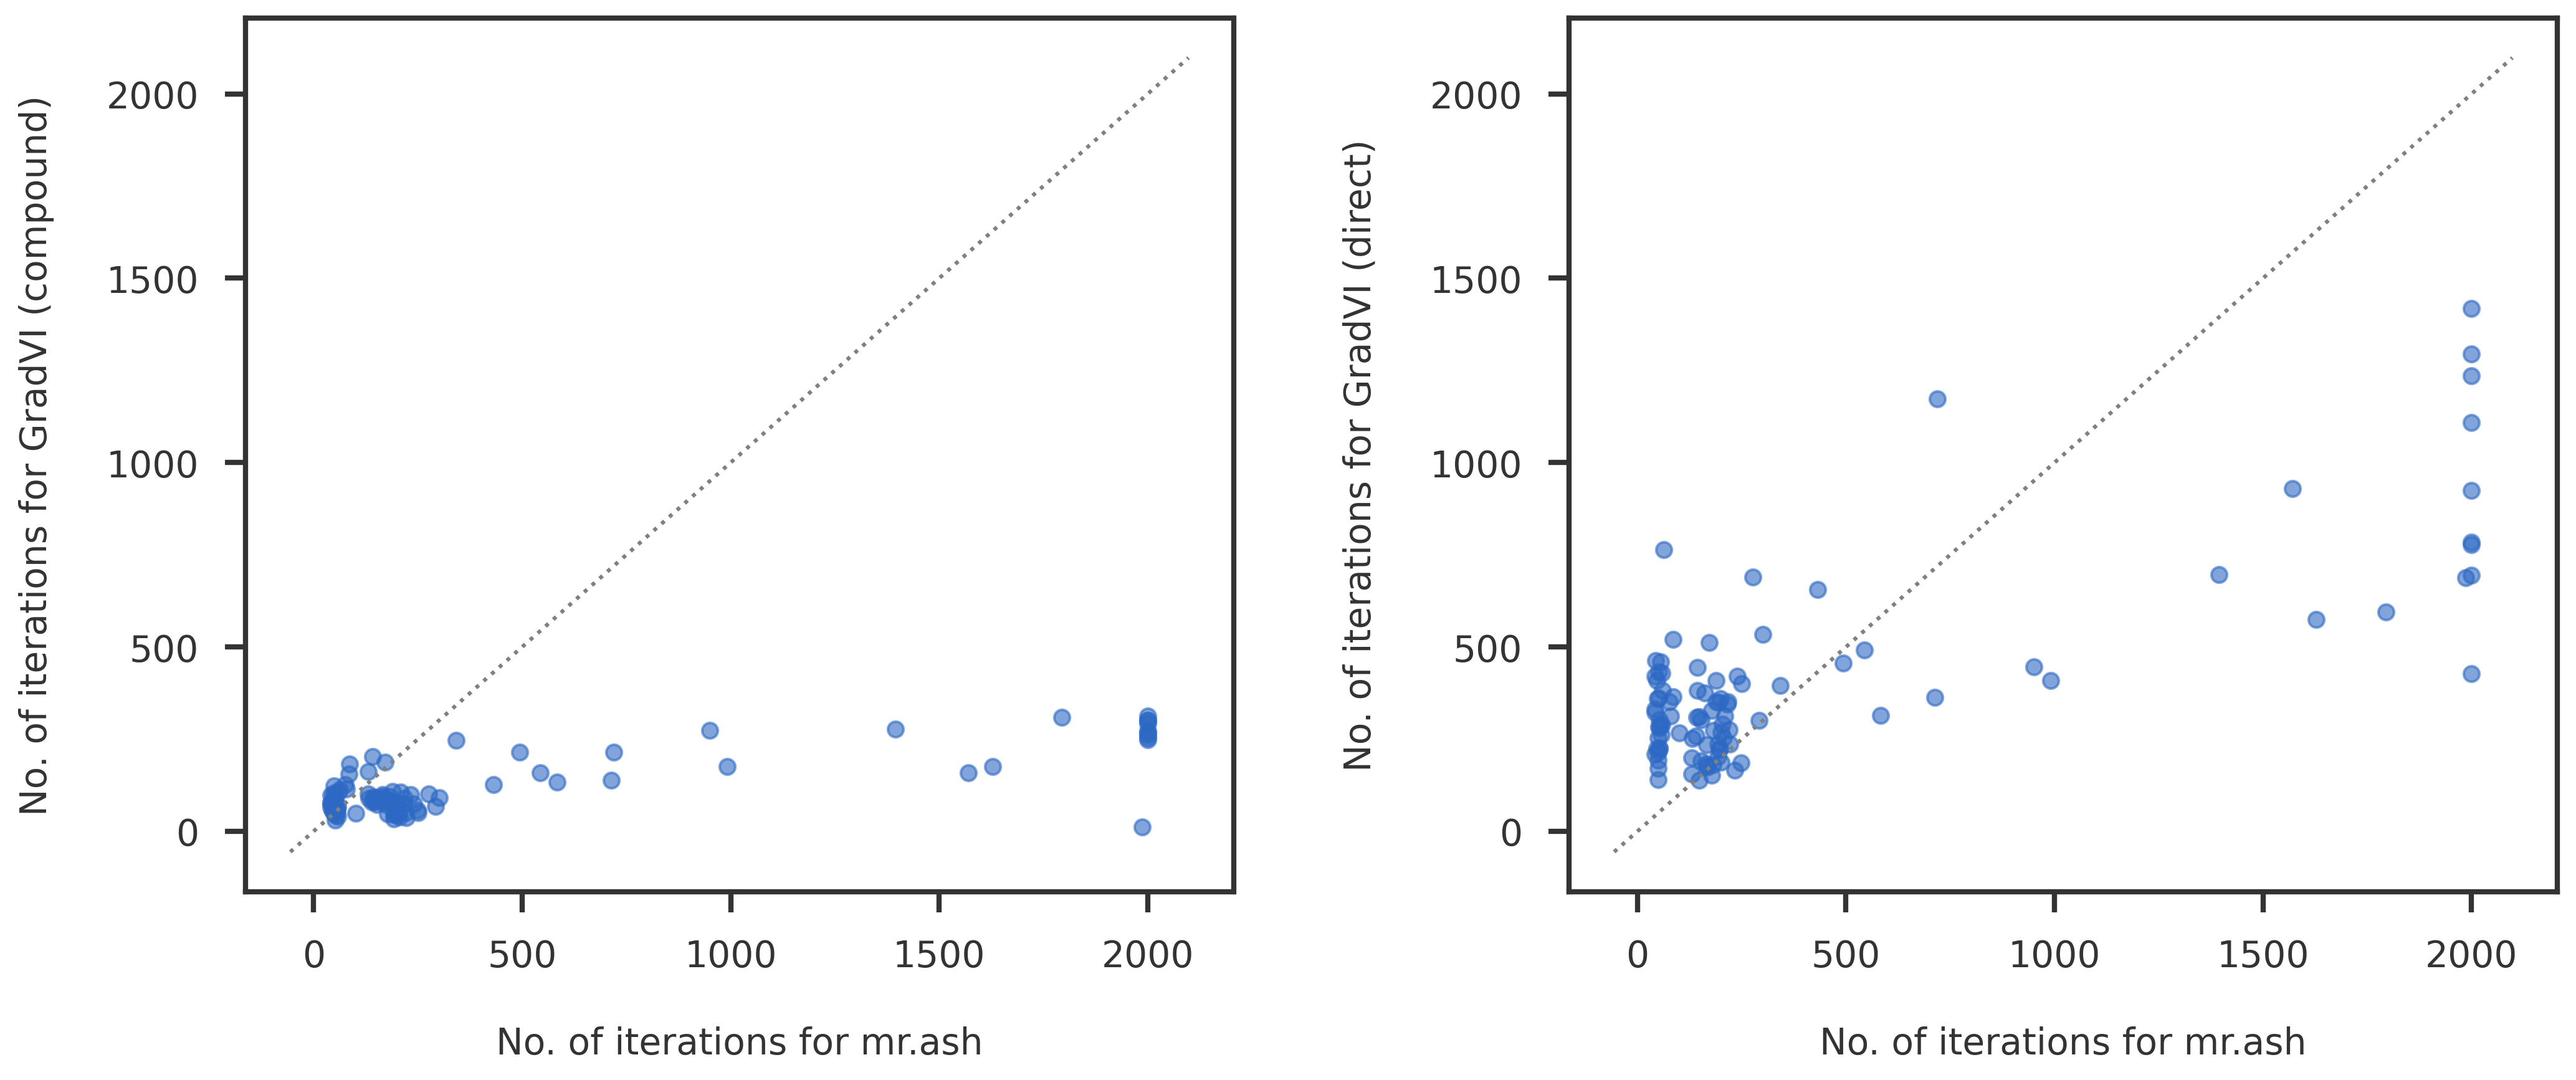

In [33]:
fig = plt.figure(figsize = (14, 6))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

#ax1.scatter(msedf['mr_ash_lasso_init'], msedf['gradvi_compound_lasso_init'])
ax1.scatter(niterdf['mr_ash_lasso_init'], niterdf['gradvi_compound_lasso_init'], alpha = 0.6)
#ax1.hist(elbodf['mr_ash_lasso_init'] - elbodf['gradvi_compound_lasso_init'])
mpl_utils.plot_diag(ax1)
ax1.set_xlabel("No. of iterations for mr.ash")
ax1.set_ylabel("No. of iterations for GradVI (compound)")

ax2.scatter(niterdf['mr_ash_lasso_init'], niterdf['gradvi_direct_lasso_init'], alpha = 0.6)
mpl_utils.plot_diag(ax2)
ax2.set_xlabel("No. of iterations for mr.ash")
ax2.set_ylabel("No. of iterations for GradVI (direct)")

plt.tight_layout(w_pad = 3.0)
utils.saveplot(fig, "linreg_corr_compare_niter_gradvi_cavi")
plt.show()

In [18]:
elbodf['mr_ash_lasso_init'] - elbodf['gradvi_compound_lasso_init']

0     88.867665
1    -34.658965
2     20.682240
3     12.158619
4     -0.012136
        ...    
95     2.914194
96    -8.100123
97    -9.314191
98   -40.958446
99    -8.929079
Length: 100, dtype: float64